In [1]:
import torch
from torch.nn import Module
from torch.nn import Sequential
from torch.nn import Conv2d, Dropout2d, MaxPool2d, ReLU, UpsamplingNearest2d

from torchsummary import summary

In [2]:
# Based on https://github.com/divamgupta/image-segmentation-keras/blob/master/keras_segmentation/models/unet.py#L19
class UNetMini(Module):

    def __init__(self, num_classes):
        super(UNetMini, self).__init__()

        self.block1 = Sequential(
            Conv2d(1, 32, kernel_size=3, padding=1),
            ReLU(),
            Dropout2d(0.2),
            Conv2d(32, 32, kernel_size=3, padding=1),
            ReLU(),
        )
        self.pool1 = MaxPool2d((2, 2))

        self.block2 = Sequential(
            Conv2d(32, 64, kernel_size=3, padding=1),
            ReLU(),
            Dropout2d(0.2),
            Conv2d(64, 64, kernel_size=3, padding=1),
            ReLU(),
        )
        self.pool2 = MaxPool2d((2, 2))

        self.block3 = Sequential(
            Conv2d(64, 128, kernel_size=3, padding=1),
            ReLU(),
            Dropout2d(0.2),
            Conv2d(128, 128, kernel_size=3, padding=1),
            ReLU()
        )

        self.up1 = UpsamplingNearest2d(scale_factor=2)
        self.block4 = Sequential(
            Conv2d(192, 64, kernel_size=3, padding=1),
            ReLU(),
            Dropout2d(0.2),
            Conv2d(64, 64, kernel_size=3, padding=1),
            ReLU()
        )

        self.up2 = UpsamplingNearest2d(scale_factor=2)
        self.block5 = Sequential(
            Conv2d(96, 32, kernel_size=3, padding=1),
            ReLU(),
            Dropout2d(0.2),
            Conv2d(32, 32, kernel_size=3, padding=1),
            ReLU()
        )

        self.conv2d = Conv2d(32, num_classes, kernel_size=1)

    def forward(self, x):
        out1 = self.block1(x)
        out_pool1 = self.pool1(out1)

        out2 = self.block2(out_pool1)
        out_pool2 = self.pool1(out2)

        out3 = self.block3(out_pool2)

        out_up1 = self.up1(out3)
        # return out_up1
        out4 = torch.cat((out_up1, out2), dim=1)
        out4 = self.block4(out4)

        out_up2 = self.up2(out4)
        out5 = torch.cat((out_up2, out1), dim=1)
        out5 = self.block5(out5)

        out = self.conv2d(out5)

        return out

In [3]:
model = UNetMini(2)

In [11]:
from torch.utils.data import Dataset, DataLoader

class AngleCharactersDataset(Dataset):
    pass


In [28]:
import numpy as np
import cv2


def create_sample(img_size, position):
    
    img = 255 * np.ones(img_size, dtype=np.uint8)

    org = (int(img_size[1]*position[1]), int(img_size[0]*position[0]))
    fontFace = cv2.FONT_HERSHEY_SIMPLEX    
    fontScale = 1
    color = (0, 0, 0)
    thickness = 2
    
    print(org)
    cv2.putText(img, '<<<<', org, fontFace, fontScale, color, thickness)
    
    return img

(250, 125)
Populating the interactive namespace from numpy and matplotlib


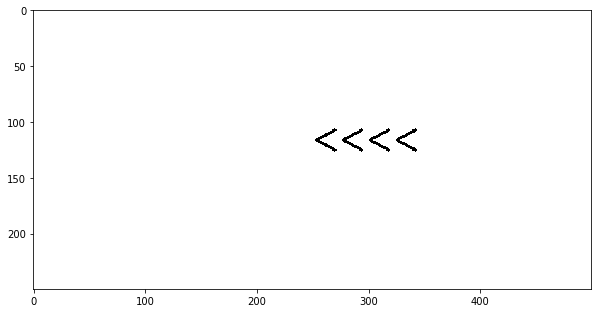

In [29]:
img = create_sample((250, 500), (.5, .5))

%pylab inline

plt.figure(figsize=(10, 10))
plt.imshow(img, cmap='gray')

In [92]:
from trdg.utils import load_fonts

In [93]:
fnts = load_fonts('en')

In [95]:
fnts[0]

'/home/xmiler/.virtualenvs/torch/lib/python3.6/site-packages/trdg/fonts/latin/Raleway-LightItalic.ttf'

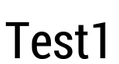

In [135]:
from trdg.generators import GeneratorFromStrings

# fnts[1, 13, 15, 19, 20, 27]
generator = GeneratorFromStrings(['Test1', 'Test2', 'Test3'], size=64, text_color='#000000', fonts=[fnts[27]], background_type=1)

for img in generator:
    # Do something with the pillow image here.
    break
    
im = np.array(img[0])
img[0]

In [483]:
800 / 650

1.2307692307692308

In [29]:
import string

import numpy as np

import cv2

from trdg.computer_text_generator import generate
from trdg.utils import load_fonts

np.random.seed(0)

CHARACTERS = list(string.ascii_letters + string.digits*3 + ':/'*2)
FONTS = load_fonts('en')

def generate_random_word(size):

    return ''.join(np.random.choice(CHARACTERS, size=size))


def create_fragment_with_text(angles_string):
    img = generate(angles_string, font=FONTS[1], text_color='#000000', font_size=64, space_width=1., fit=False, orientation=0)
    return cv2.bitwise_not(np.array(img)[:, :, 3])  # library "trdg" writes result to alpha channel. Convert to grey.


def put_fragment(img, crop, pt):
    size = (min(img.shape[0]-pt[0], crop.shape[0]),
            min(img.shape[1]-pt[1], crop.shape[1]))
    
    img[pt[0]:pt[0]+size[0], pt[1]:pt[1]+size[1]] = crop[:size[0], :size[1]]

    
def create_bare_card_image(size):
    """
    Creates image with pattern text, i.e. that consist of ' ' or '<' characters. 
    From that point one can put any synthetic artifacts within image.
    Returns result image and extra parameters to restore current zone of interest.
    """
    def generate_pattern_text(max_size, pieces_num = 4, piece_max_len = 20):
        while True:
            rnd_flags = np.random.randint(0, high=2, size=pieces_num)
            rnd_lens = np.random.randint(1, high=piece_max_len+1, size=(pieces_num))

            pieces = [(' ' if f else '<')*n for f, n in zip(rnd_flags, rnd_lens)]
            angles_string = ''.join(pieces)[:max_size]

            if '<' in angles_string:
                break

        return angles_string
    
        
    output_image = 255 * np.ones(size, dtype=np.uint8)    
    
    patter_texts_num = 3
    patter_text_size = 20
    
    pattern_texts = [generate_pattern_text(patter_text_size) for _ in range(patter_texts_num)]    

    pt_xs = np.random.randint(0, high=100)*np.ones((patter_texts_num), dtype=np.int)
    pt_ys = size[0] - np.cumsum(np.random.randint(50, high=100, size=(patter_texts_num)))
    
    pts = list(zip(pt_ys, pt_xs))
    
    pattern_text_images = [create_fragment_with_text(pattern_text) for pattern_text in pattern_texts]
    for img_i in range(len(pattern_text_images)):        
        put_fragment(output_image, pattern_text_images[img_i], (pts[img_i]))
    
    
    return output_image, pattern_texts, pts


def add_noise_to_pattern_text(pattern_text):
    pattern_text_noised = ''.join([ch if ch == '<' else generate_random_word(1) for ch in pattern_text])
    return pattern_text_noised

In [44]:
DST_SIZE = (650, 800)

image, pattern_texts, pattern_text_images_pts = create_bare_card_image(DST_SIZE)

image_gt = cv2.bitwise_not(image)

# showarray(image_gt)

pattern_texts = [add_noise_to_pattern_text(pattern_text) for pattern_text in pattern_texts]



pattern_texts

['Da72d95q1:404<<<<<<<', '<<<<<<<<<<<<<<<<<<<<', '<<<<<<Wr5j076Heq90xh']

In [730]:
np.random.choice(image_face_paths, 1)[0]

PosixPath('images4augment/faces/part1/30b.jpg')

In [1]:
import io
import string
from pathlib import Path

import numpy as np
from numpy.random import randint

import cv2
import PIL.Image

from trdg.computer_text_generator import generate
from trdg.utils import load_fonts

from IPython.display import clear_output, Image, display


np.random.seed(0)


CHARACTERS = list(string.ascii_letters + string.digits*3 + ':/'*2)
FONTS = [font for i, font in enumerate(load_fonts('en')) if i in [1, 2, 15, 19, 22, 23, 24, 27, 35, 49]]  # picked MRZ like fonts

image_face_paths = sorted([path for path in Path('images4augment').glob('**/*') if path.is_file()])


def generate_random_word(size, uppercase=False):
    characters_set = list(string.ascii_uppercase) if uppercase else CHARACTERS    
    return ''.join(np.random.choice(characters_set, size=size))

def create_image_with_text(text, font_id=None, font_size=None):
    if font_id is None:
        font_id = randint(0, high=len(FONTS))
    if font_size is None:
        font_size = randint(16, high=64)
    img = generate(text, font=FONTS[font_id], text_color='#000000', font_size=font_size, space_width=1., fit=False, orientation=0)
    return cv2.bitwise_not(np.array(img)[:, :, 3])  # library "trdg" writes result to alpha channel. Convert to grey.

def generate_random_face(size):
    image_face_path = np.random.choice(image_face_paths, 1)[0]
    image_face = cv2.imread(image_face_path.as_posix(), cv2.IMREAD_GRAYSCALE)
    h_, w_ = image_face.shape
    size_ = max(h_, w_)
    h = int(h_ * size / size_)
    w = int(w_ * size / size_)
    image_face = cv2.resize(image_face, (w, h))
    return image_face

def show_array(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    if a.ndim == 3:
        a = a[:, :, ::-1]  # BGR2RGB
    
    f = io.BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))


class SyntheticCardImageGenerator():
    CARD_SIZE = (650, 800)
    PATTERN_TEXTS_NUM = 3
    
    def __init__(self):        
        """
        Creates image with pattern text, i.e. that consist of ' ' or '<' characters. 
        From that point one can put any synthetic artifacts within image.
        Stores result image and extra parameters to restore current zone of interest.
        """
        self._image = 255 * np.ones(self.CARD_SIZE, dtype=np.uint8) 
        
        # generate bare pattern texts
        self._pattern_texts = [self.generate_pattern_text_bare() for _ in range(self.PATTERN_TEXTS_NUM)]    

        # patternt texts drawing parameters
        pt_xs = randint(0, high=100)*np.ones((self.PATTERN_TEXTS_NUM), dtype=np.int)
        pt_ys = self.CARD_SIZE[0] - np.cumsum(randint(50, high=100, size=(self.PATTERN_TEXTS_NUM)))
        pt_ys -= 10
        self._pattern_text_imgs_pt = list(zip(pt_ys, pt_xs))
        font_id = randint(0, high=len(FONTS))
        font_size = 60

        # draw bare pattern texts
        self._pattern_text_imgs = [create_image_with_text(pattern_text, font_id=font_id, font_size=font_size) for pattern_text in self._pattern_texts]
        self.draw_pattern_texts()
        
        # store ground truth
        self._image_gt = cv2.bitwise_not(self._image)
        
        # redraw with non-bare pattern text 
        self._pattern_texts = [''.join([ch if ch == '<' else generate_random_word(1, uppercase=True) for ch in pattern_text]) for pattern_text in self._pattern_texts]
        self._pattern_text_imgs = [create_image_with_text(pattern_text, font_id=font_id, font_size=font_size) for pattern_text in self._pattern_texts]
        self.draw_pattern_texts()

    @property
    def image(self):
        return self._image
    
    @property
    def image_gt(self):
        return self._image_gt
    
    def show(self):
        show_array(self._image)
        
    def put_fragment(self, fragment, pt=None):
        if pt is None:
            pt = tuple([randint(0, high=self.CARD_SIZE[i]) for i in [0, 1]])
        size = (min(self._image.shape[0]-pt[0], fragment.shape[0]),
        min(self._image.shape[1]-pt[1], fragment.shape[1]))
        self._image[pt[0]:pt[0]+size[0], pt[1]:pt[1]+size[1]] = fragment[:size[0], :size[1]]
                
    def draw_pattern_texts(self):
        for img_i in range(self.PATTERN_TEXTS_NUM):        
            self.put_fragment(self._pattern_text_imgs[img_i], self._pattern_text_imgs_pt[img_i])       
    
    @staticmethod
    def generate_pattern_text_bare(max_size = 16, pieces_num = 10, piece_max_len = 20):
        while True:
            rnd_flags = randint(0, high=2, size=pieces_num)
            rnd_lens = randint(1, high=piece_max_len+1, size=(pieces_num))

            pieces = [(' ' if f else '<')*n for f, n in zip(rnd_flags, rnd_lens)]
            pattern_text_bare = ''.join(pieces)[:max_size]

            if '<' in pattern_text_bare:
                break
        return pattern_text_bare    


In [2]:
card_image = SyntheticCardImageGenerator()
# card_image.show()

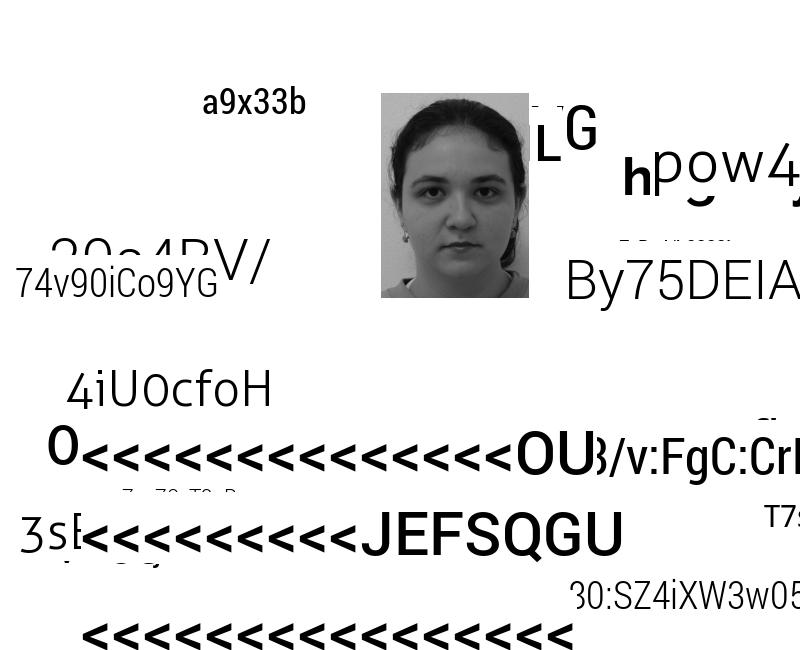

In [20]:
card_image = SyntheticCardImageGenerator()

for _ in range(25):
    text = generate_random_word(randint(5, 20))
    text_image = create_image_with_text(text)    
    card_image.put_fragment(text_image)
    
face_image = generate_random_face(randint(150, 350))

card_image.put_fragment(face_image)

card_image.draw_pattern_texts()

card_image.show()

In [839]:
from pathlib import Path


In [840]:
im = generate_random_face(200)
im.shape

(200, 144)

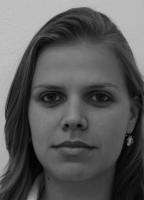

In [841]:
show_array(im)

In [698]:
card_image.image.shape

(650, 800)

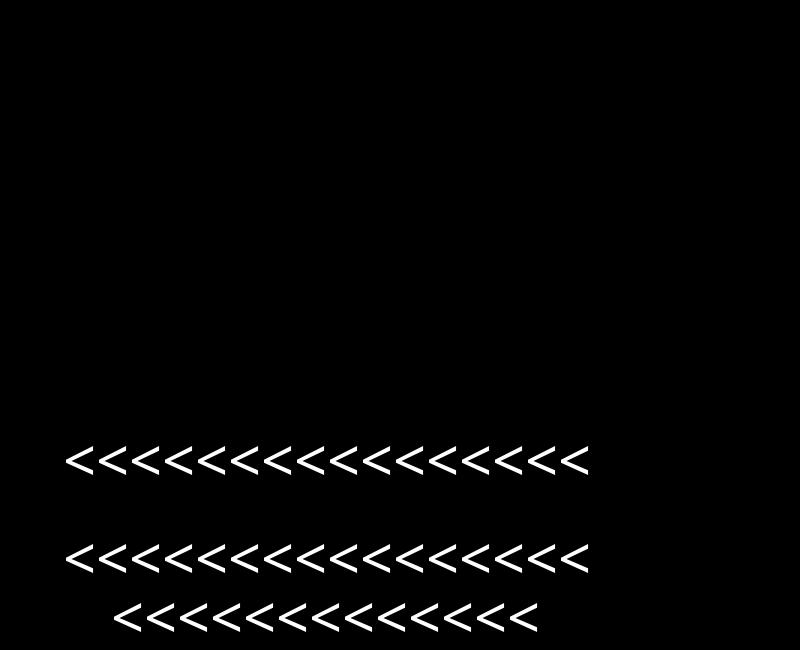

In [690]:
show_array(card_image.image_gt)

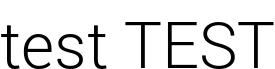

In [61]:
def create_image_with_text(text):
    img = generate(text, font=FONTS[49], text_color='#000000', font_size=64, space_width=1., fit=False, orientation=0)
    return cv2.bitwise_not(np.array(img)[:, :, 3])  # library "trdg" writes result to alpha channel. Convert to grey.


show_array(create_image_with_text('test TEST'))

In [38]:
[1, 2, 15, 19, 22, 23, 24, 27, 35, 49]

[1, 2, 15, 19, 22, 23, 24, 27]

In [61]:
card_image.add_noise_to_pattern_text()
card_image.pattern_texts

['<<<<aK1fMr7eQ6Fb<<<<', '<<<<<<<<<<<<<<<<<<<<', '<<<<<<<<<<3<<<<<<<<<']

In [64]:
len(FONTS)

10

In [45]:
len(FONTS)

100

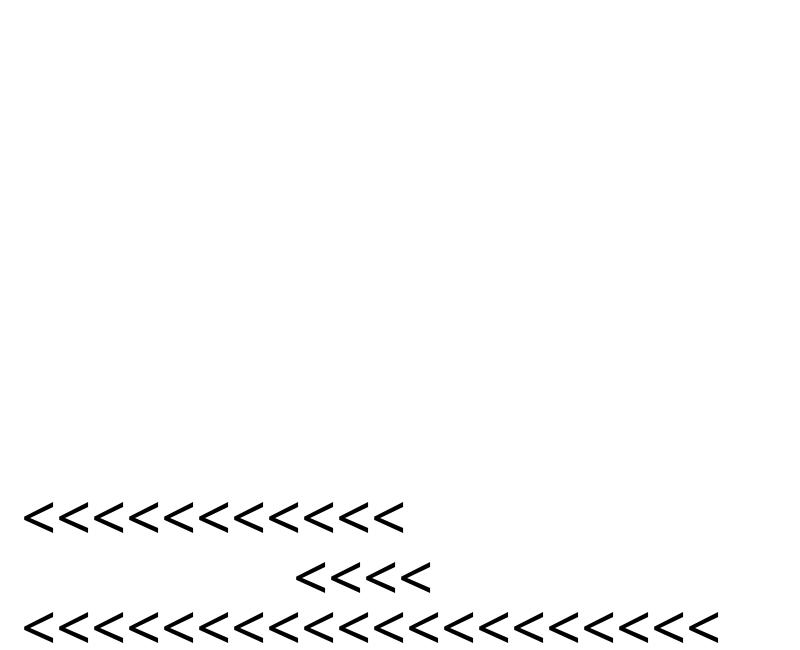

In [25]:
showarray(card_image._image)

In [18]:
angle_string = angles_strings[1]
angle_string

'<<<            <<<<<'

In [31]:
pattern_texts

['<<<<aK1fMr7eQ6Fb<<<<', '<<<<<<<<<<<<<<<<<<<<', '<<<<<<<<<<3<<<<<<<<<']

In [212]:
''.join([ch if ch == '<' else '-' for ch in angle_string])

'<<<<<<<<<<<<<<<<<<<<'

In [208]:
generate_random_word(10)

':I9EB100:x'

In [159]:
''.join(np.random.choice(CHARACTERS, size=10))

'yr0if:k0Dl'

In [94]:
string.ascii_letters

'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'

In [20]:
import io
from IPython.display import clear_output, Image, display
import PIL.Image

def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    f = io.BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

Populating the interactive namespace from numpy and matplotlib


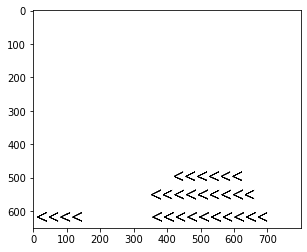

In [3]:
%pylab inline

plt.imshow(output_image, cmap='gray', vmin=0, vmax=255)

Populating the interactive namespace from numpy and matplotlib


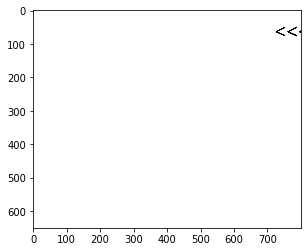

In [637]:
import torchvision

In [640]:
background_images = torchvision.datasets.Flickr8k('background_images', './background_images_ann')

IsADirectoryError: [Errno 21] Is a directory: './background_images_ann'

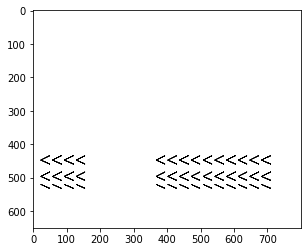

In [501]:

pt_x_angles_string

35

In [500]:
pt_ys_angles_string

array([374, 275, 196])

In [498]:
DST_SIZE[0] - pt_ys_angles_string

array([415, 301, 169])

In [492]:
pt_x_angles_string

9

In [481]:
output_image = 255 * np.ones((650, 800), dtype=np.uint8)

put_crop(output_image, angles_string_images[0], (500, 0))
put_crop(output_image, angles_string_images[0], (600, 0))

(60, 762)
(50, 762)


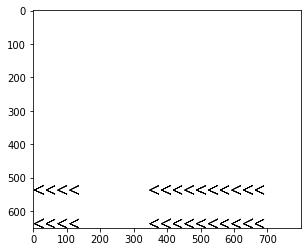

In [482]:
plt.imshow(output_image, cmap='gray', vmin=0, vmax=255)

In [455]:
output_image

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

In [414]:
image_bottom = np.concatenate(angles_string_images, axis=0)

ValueError: all the input array dimensions except for the concatenation axis must match exactly

In [403]:
angles_string_images[1].shape

(60, 618)

In [402]:
angles_string_images[0].shape

(60, 762)

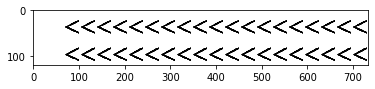

In [383]:
plt.imshow(image_bottom, cmap='gray')

In [287]:
image_bottom.shape

(120, 733, 3)

In [286]:
image_bottom.ndim

3

Populating the interactive namespace from numpy and matplotlib


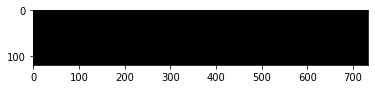

In [288]:
%pylab inline

plt.imshow(image_bottom)

In [285]:
image_bottom.shape

(120, 733, 3)

In [246]:
s

'<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<'

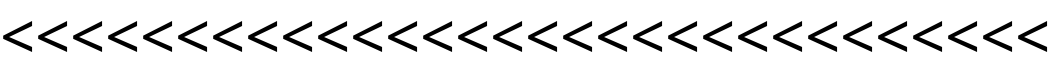

In [134]:
im[im == 0]

array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)

In [126]:
import numpy as np

In [54]:
g3 = GeneratorFromDict()

In [83]:
for img in g3:
    # Do something with the pillow image here.
    break
    
im = img[0]

In [71]:
import trdg

In [82]:
from trdg.background_generator import ImageDraw

In [ ]:
Image.

In [76]:
ImageDraw.ImageDraw(im)

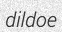

In [79]:
ImageFilter.

In [ ]:
from trdg.generators import 

In [2]:
import numpy as np
import cv2


img = 255 * np.ones((256, 256), dtype=np.uint8)

# font 
font = cv2.FONT_HERSHEY_SIMPLEX 
  
# org 
org = (50, 50) 
  
# fontScale 
fontScale = 1
   
# Blue color in BGR 
color = (255, 0, 0) 
  
# Line thickness of 2 px 
thickness = 2
   
# Using cv2.putText() method 
cv2.putText(img, 'OpenCV', org, font, fontScale, color, thickness, cv2.LINE_AA) 
   

TypeError: Expected cv::UMat for argument 'img'

In [9]:
summary(model, input_size=(1, 256, 256), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             320
              ReLU-2         [-1, 32, 256, 256]               0
         Dropout2d-3         [-1, 32, 256, 256]               0
            Conv2d-4         [-1, 32, 256, 256]           9,248
              ReLU-5         [-1, 32, 256, 256]               0
         MaxPool2d-6         [-1, 32, 128, 128]               0
            Conv2d-7         [-1, 64, 128, 128]          18,496
              ReLU-8         [-1, 64, 128, 128]               0
         Dropout2d-9         [-1, 64, 128, 128]               0
           Conv2d-10         [-1, 64, 128, 128]          36,928
             ReLU-11         [-1, 64, 128, 128]               0
        MaxPool2d-12           [-1, 64, 64, 64]               0
           Conv2d-13          [-1, 128, 64, 64]          73,856
             ReLU-14          [-1, 128,